Steps for Fine-tuning the Model for Perturb Protein Prediction:
1.  Prepare Your Environment: Ensure you have the necessary Python libraries installed (as indicated in the original script).
2.  Download Datasets and Pre-trained Model: Obtain the gene and protein expression data files for training and testing, as well as the pre-trained model files. We have prepared a test dataset for code testing.
3.  Organize File Paths: Use our default path structure or Make sure the paths to your data files and the pre-trained model are correctly specified
4.  Execute the Python Script: Run the Python script from your terminal, providing the required parameters to control the fine-tuning process.
5.  Locate Output Files: After the script finishes, the fine-tuned model, generated feature files and predicted results will be saved in the results directory (Please download our dataset, fine-tuned models, generated feature files from https://drive.google.com/drive/folders/1c8nlX3lOUVTn75ijhTeAaD9ZW1VBGvn4?usp=drive_link)


Python Command to Run Fine-tuning:

cd /home/captain/downstream_tasks/perturb_protein_prediction && python finetune.py --data_rna_path perturb_gene_train_demo.h5ad --data_protein_path perturb_protein_train_demo.h5ad --species "human"


Python Command to perturb protein prediction:

cd /home/captain/downstream_tasks/perturb_protein_prediction && python genate.py --data_rna_path perturb_gene_test_demo.h5ad --data_protein_path perturb_protein_test_demo.h5ad --species "human"

Explanation of the Command:

`--species`: Specifies the species of the dataset. Use human or mouse. Default is human.

`--data_rna_path`: Required. Provides the path to the RNA data file (e.g., rna.h5ad).

`--data_adt_path`: Required. Provides the path to the ADT (protein expression) data file (e.g., adt.h5ad).

`--batch_size`: Inference batch size.

`--layer_size`: Model embedding size (default: 128).

`--nlayers`: Number of transformer layers.

`--nhead`: Number of attention heads.


"Use our default path structure or Remember to adjust the file paths according to the actual location of your data and pre-trained model. You can also modify other parameters as needed based on your specific requirements."

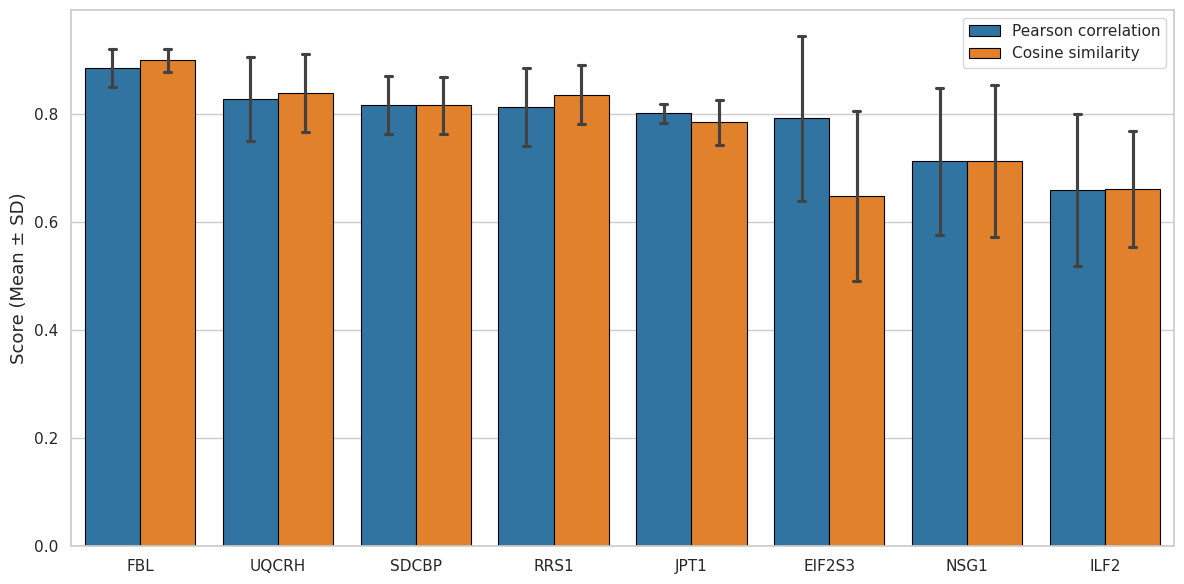

Plot saved to: /home/jiboya/Captain/perturb/dataset1/gene_performance_custom_color.png


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


summary_path = '/home/jiboya/Captain/perturb/dataset1/gene_target_summary_cosine.csv'
detail_path = '/home/jiboya/Captain/perturb/dataset1/gene_target_detailed_cosine.csv'

df_summary = pd.read_csv(summary_path)
df_detail = pd.read_csv(detail_path)


genes_show = df_summary.sort_values(by='Mean_Pearson', ascending=False).head(8)['Gene_Target'].tolist()

plot_df = df_detail[df_detail['Gene_Target'].isin(genes_show)].copy()

plot_df_melted = plot_df.melt(
    id_vars=['Gene_Target'], 
    value_vars=['Pearson', 'Cosine'], 
    var_name='Metric', 
    value_name='Score'
)


plot_df_melted['Metric'] = plot_df_melted['Metric'].replace({
    'Pearson': 'Pearson correlation',
    'Cosine': 'Cosine similarity'
})


custom_palette = {
    "Pearson correlation": "#1f77b4",  
    "Cosine similarity": "#ff7f0e" 
}


sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

ax = sns.barplot(
    data=plot_df_melted,
    x='Gene_Target',
    y='Score',
    hue='Metric',
    order=genes_show,
    palette=custom_palette,
    errorbar='sd',
    capsize=0.1,
    edgecolor="black",
    linewidth=0.8
)




ax.set_xlabel(None) 


plt.ylabel('Score (Mean ± SD)', fontsize=13)


plt.xticks(fontsize=11)


plt.legend(title=None, loc='upper right', frameon=True, fontsize=11)

plt.tight_layout()


save_plot_path = '/home/jiboya/Captain/perturb/dataset1/gene_performance_custom_color.png'
plt.savefig(save_plot_path, dpi=300)
plt.show()

print(f"Plot saved to: {save_plot_path}")

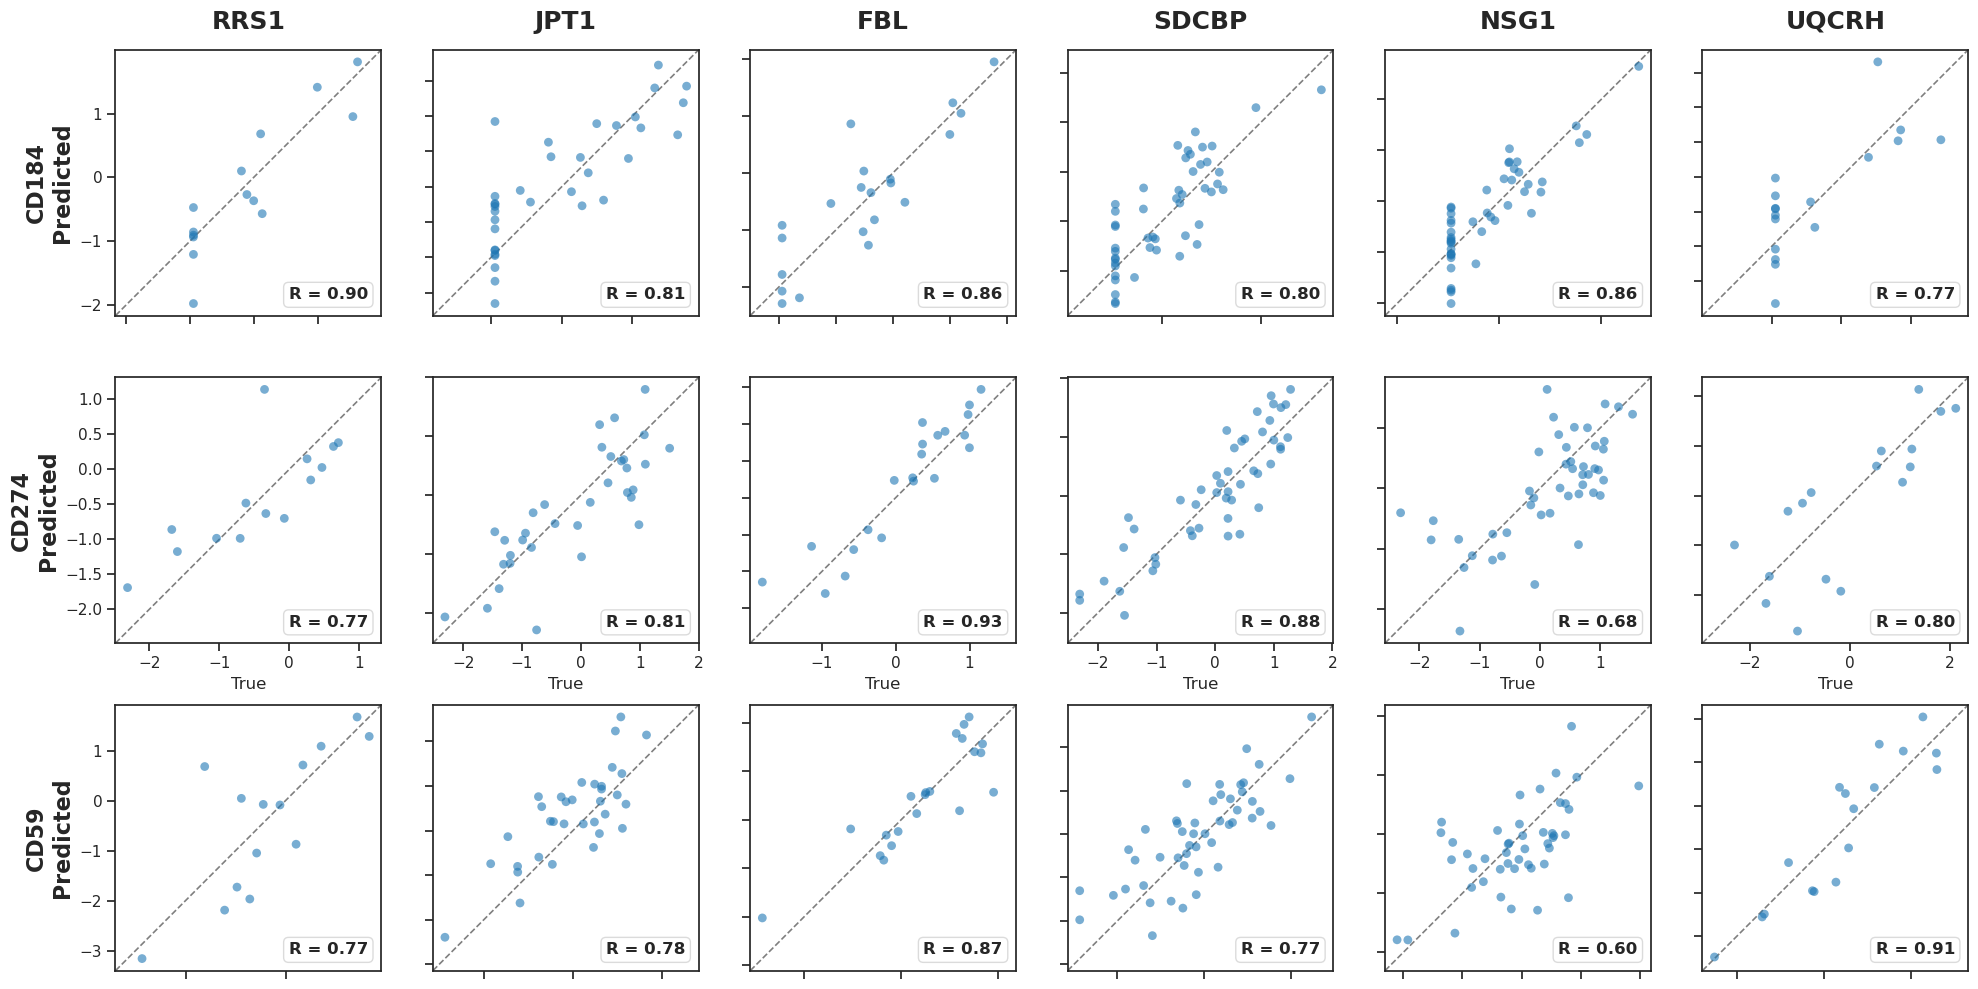

Plot saved to: /home/jiboya/Captain/perturb/dataset1/target_genes_protein_scatter_matrix.png


In [ ]:
import pandas as pd
import pickle as pkl
import numpy as np
from scipy.stats import pearsonr
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns


adata_gene = sc.read_h5ad("/home/jiboya/Captain/perturb/dataset1/test_adata.h5ad")
adata_protein = sc.read_h5ad("/home/jiboya/Captain/perturb/dataset1/test_adt.h5ad")

with open('/home/jiboya/Captain/perturb/dataset1/true_adt_data_scale.pickle', 'rb') as fp:
    true_adt_data = np.array(pkl.load(fp))

with open('/home/jiboya/Captain/perturb/dataset1/predicted_adt_scale.pickle', 'rb') as fp:
    predicted_adt_data = np.array(pkl.load(fp))

with open('/home/jiboya/Captain/token_dict/adt_token_dict.pickle', 'rb') as fp:
    adt_token_dict = pkl.load(fp)


adata_gene.obs['gene_target'] = adata_gene.obs['sgRNA'].astype(str).str.split('_').str[0]


target_genes = ["RRS1", "JPT1", "FBL", "SDCBP","NSG1","UQCRH"]
target_proteins = ["CD184","CD274", "CD59"]


for p in target_proteins:
    if p not in adt_token_dict:
        raise ValueError(f"Protein {p} not found in token dictionary.")


sns.set_theme(style="ticks")


fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(20, 10))


for row_idx, protein in enumerate(target_proteins):
    prot_col_idx = adt_token_dict[protein]
    
    for col_idx, gene in enumerate(target_genes):
        ax = axes[row_idx, col_idx]
        

        cell_mask = (adata_gene.obs['gene_target'] == gene).values
        n_cells = np.sum(cell_mask)
        
        if n_cells > 0:

            x_vals = true_adt_data[cell_mask, prot_col_idx]
            y_vals = predicted_adt_data[cell_mask, prot_col_idx]
            

            if np.std(x_vals) == 0 or np.std(y_vals) == 0:
                pearson_val = 0 
            else:
                pearson_val, _ = pearsonr(x_vals, y_vals)

            ax.scatter(x_vals, y_vals, c='#1f77b4', alpha=0.6, edgecolors='none', s=40, zorder=2)
            

            min_limit = min(x_vals.min(), y_vals.min())
            max_limit = max(x_vals.max(), y_vals.max())
            padding = (max_limit - min_limit) * 0.05
            if padding == 0: padding = 0.1
            limit_range = [min_limit - padding, max_limit + padding]
            
            ax.set_xlim(limit_range)
            ax.set_ylim(limit_range)
            

            ax.plot(limit_range, limit_range, ls="--", c="black", alpha=0.5, lw=1.2, zorder=1)
            

            ax.text(0.95, 0.05, f'R = {pearson_val:.2f}', 
                    transform=ax.transAxes, ha='right', va='bottom', 
                    fontsize=12, fontweight='bold',
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='lightgray', boxstyle='round,pad=0.3'))
        else:

            ax.text(0.5, 0.5, "No Cells", ha='center', transform=ax.transAxes)


        
        ax.set_aspect('equal') 

        if row_idx == 0:
            ax.set_title(gene, fontsize=18, fontweight='bold', pad=15)
        

        if row_idx == 1:
            ax.set_xlabel("True", fontsize=12)
        else:
            ax.set_xlabel("")
            ax.set_xticklabels([]) 

        if col_idx == 0:

            ax.set_ylabel(f"{protein}\nPredicted", fontsize=16, fontweight='bold')
        else:
            ax.set_ylabel("")
            ax.set_yticklabels([]) 

plt.tight_layout()


save_path = '/home/jiboya/Captain/perturb/dataset1/target_genes_protein_scatter_matrix.png'
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Plot saved to: {save_path}")